# Проект "Предсказание стоиомости автомобилей"

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки:**

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

NotRepaired — была машина в ремонте или нет

DateCreated — дата создания анкеты¶

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

**Целевой признак:**¶

Price — цена (евро)

# 1. Подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OrdinalEncoder
import time
from datetime import timedelta

In [2]:
df=pd.read_csv('/datasets/autos.csv')

In [3]:
df.to_csv('autos.csv')

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Мы наблюдаем пропуски по некоторым столбцам, а именно VehicleType (тип кузова), Gearbox (тип КПП), Model, FuelType (тип топлива), NotRepaired (сведения о нахождении в ремонте). Наличие пропусков возможно вызвано  тем, что пользователи сервиса не внесли информацю по данным параметрам, а возможно ввиду какого-то технического сбоя. В данном случае пропуски мы удалим, так как заполнение данных признаков приведет к некорректному результату обучения и, соответственно, предсказания модели.

Также наблюдаем проблемы, связанные с типами данных, например по таким столбцам, как DateCrawled, DateCreated, LastSeen, однако в дальнейшем посмотрим, возможно некоторые из этих признаков мы удалим как лишние переменные. 

посмотрим на распределение значений целевого признака, а также на распределение значений основных признаков, влияющих на конечную цену авто

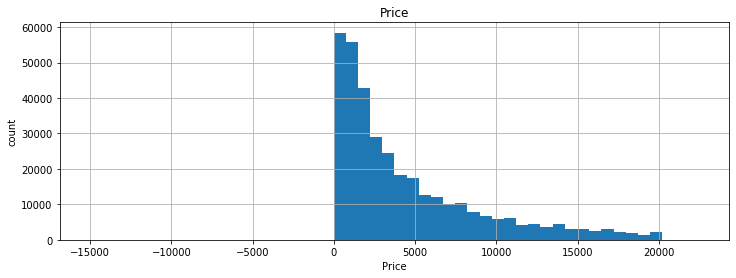

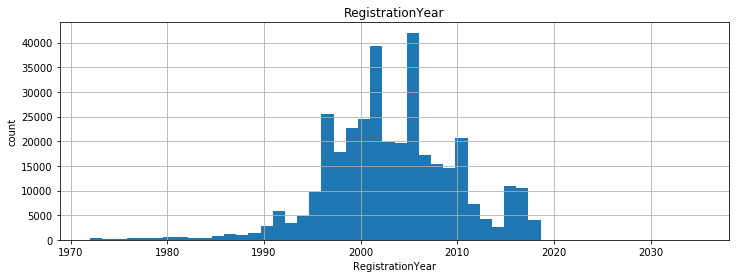

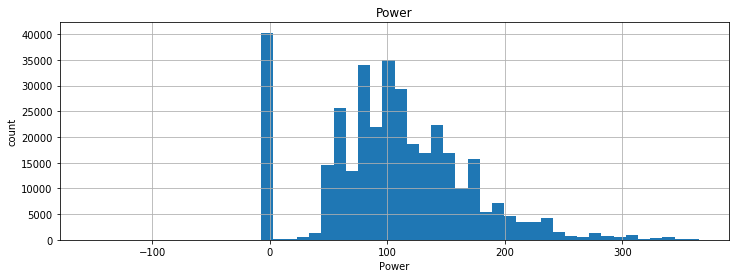

In [6]:
for column in ['Price', 'RegistrationYear', 'Power']:
    Q1=df[column].quantile(0.25)
    Q3=df[column].quantile(0.75)
    IQR=Q3-Q1
    df[column].hist(bins =50, range=(Q1-3*IQR, Q3+3*IQR),figsize=(12,4))
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel("count")
    plt.show()

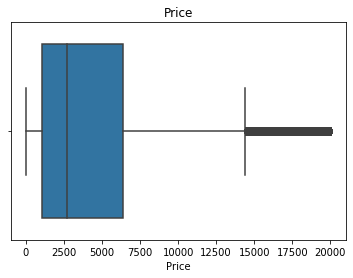

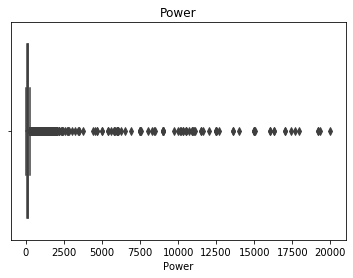

In [7]:
for column in ['Price', 'Power']:
    sns.boxplot(df[column]);
    plt.title(column)
    plt.show()

удалим все пропуски

In [8]:
df=df.dropna()

Удаляем выбросы по цене, а именно удаляем все значения, которые располагаются ниже нижнего квантиля

In [9]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,245814.000000,245814.000000,245814.000000,245814.000000,245814.000000,245814.0,245814.000000
mean,5125.346717,2002.918699,119.970884,127296.716216,6.179701,0.0,51463.186002
std,4717.948673,6.163765,139.387116,37078.820368,3.479519,0.0,25838.058847
min,0.000000,1910.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1499.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30966.000000
50%,3500.000000,2003.000000,110.000000,150000.000000,6.000000,0.0,50769.000000
75%,7500.000000,2007.000000,150.000000,150000.000000,9.000000,0.0,72379.000000
max,20000.000000,2018.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [10]:
df_price_cut = pd.qcut(df['Price'], 50)

In [11]:
df_price_cut.value_counts(normalize=True, sort=False).reset_index()

,index,Price
0,"(-0.001, 150.0]",0.020674
1,"(150.0, 355.0]",0.019336
2,"(355.0, 500.0]",0.025706
3,"(500.0, 600.0]",0.019787
4,"(600.0, 700.0]",0.018900
5,"(700.0, 800.0]",0.022082
6,"(800.0, 900.0]",0.019560
7,"(900.0, 999.0]",0.021244
8,"(999.0, 1050.0]",0.012847
9,"(1050.0, 1200.0]",0.028709


 Удаляем выбросы по году регистрации, а именно все, что до 1980 года

In [12]:
df=df.loc[(df['Price']>1000) &(df['Price']<20000)]

In [13]:
df=df.loc[(df['RegistrationYear']>1980)& (df['RegistrationYear']<=2016)]

Удаляем выбросы по мощности

In [14]:
df=df.loc[(df['Power']>70)&(df['Power']<300)]

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
аналитически, тут также, как и сценой лучше поступать.

**согласен**

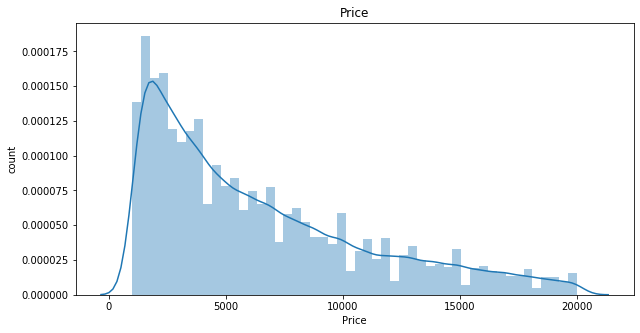

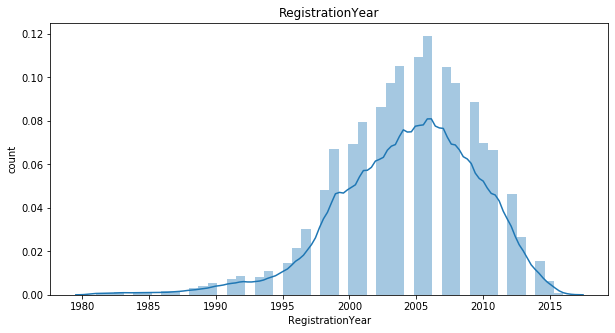

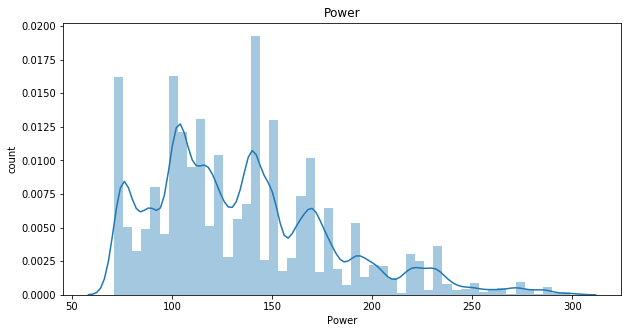

In [15]:
for column in ['Price', 'RegistrationYear', 'Power']:
    plt.figure(figsize=(10,5))
    sns.distplot(df[column])
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel("count")
    plt.show()

In [16]:
df.isnull().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

удаляем лишние переменные

In [17]:
del df['LastSeen']
del df['DateCreated']
del df['DateCrawled']
del df['RegistrationMonth']
del df['PostalCode']
del df['NumberOfPictures']

In [18]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes
14,17999,suv,2011,manual,190,navara,70000,gasoline,nissan,no


# 2. Обучение моделей

In [19]:
target=df['Price']
features=df.drop(['Price'],axis=1)

In [20]:
train_features,valid_features,train_target,valid_tagret=train_test_split(features,target,test_size=0.3,random_state=12345)

Определим индексы для столбцов нецелочисленного типа, то есть найдем категориальные столбцы


In [21]:
cat_feat=np.where(features.dtypes!= np.int64)[0]
cat_feat

array([0, 2, 4, 6, 7, 8])

**CatBoostingRegressor**

найдем лучшие гиперпараметры, используя компонент GridSearchCV

In [22]:

model = CatBoostRegressor()
parameters = {'depth'         : [2,8,10],
                 'learning_rate' : [0.1,0.5],
                 'iterations'    : [400,700]
                }
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(train_features,train_target,cat_features=cat_feat,verbose=100)    


print("\n========================================================")
print(" Результаты Grid Search " )
print("========================================================")    
    
print("\n The best estimator across ALL searched params:\n",
          grid.best_estimator_)
    
print("\n The best score across ALL searched params:\n",
          grid.best_score_)
    
print("\n The best parameters across ALL searched params:\n",
          grid.best_params_)
    
print("\n ========================================================")

0:	learn: 4441.1668620	total: 102ms	remaining: 40.8s
100:	learn: 2055.9164479	total: 6.94s	remaining: 20.6s
200:	learn: 1971.6804624	total: 13.3s	remaining: 13.2s
300:	learn: 1919.9414839	total: 19.8s	remaining: 6.51s
399:	learn: 1889.1958681	total: 26s	remaining: 0us
0:	learn: 4446.6124012	total: 13.2ms	remaining: 5.26s
100:	learn: 2049.9188654	total: 6.77s	remaining: 20.1s
200:	learn: 1961.5531223	total: 13.1s	remaining: 13s
300:	learn: 1918.8781829	total: 19.3s	remaining: 6.35s
399:	learn: 1888.1612286	total: 25.4s	remaining: 0us
0:	learn: 3667.0676314	total: 10.8ms	remaining: 4.31s
100:	learn: 1879.6906598	total: 7.05s	remaining: 20.9s
200:	learn: 1811.0138168	total: 13.5s	remaining: 13.4s
300:	learn: 1786.2307130	total: 20.1s	remaining: 6.62s
399:	learn: 1771.0032524	total: 26.7s	remaining: 0us
0:	learn: 3676.9124869	total: 10.5ms	remaining: 4.2s
100:	learn: 1883.6503087	total: 7.61s	remaining: 22.5s
200:	learn: 1821.2194331	total: 14.5s	remaining: 14.4s
300:	learn: 1794.3036449	t

Произведем обучение модели, применив лучшие гиперпарамтеры, а также получим результаты предсказания и показатель метрики rmse, отобразив все в графическом виде

0:	learn: 4331.5106519	total: 599ms	remaining: 6m 58s
100:	learn: 1635.0398987	total: 1m 3s	remaining: 6m 14s
200:	learn: 1545.9484045	total: 2m 7s	remaining: 5m 16s
300:	learn: 1497.7007620	total: 3m 15s	remaining: 4m 19s
400:	learn: 1466.0189143	total: 4m 22s	remaining: 3m 16s
500:	learn: 1437.6739402	total: 5m 30s	remaining: 2m 11s
600:	learn: 1414.5085416	total: 6m 39s	remaining: 1m 5s
699:	learn: 1396.4110093	total: 7m 48s	remaining: 0us
RMSE:  1579.3095087397176
Время выполнения: 0:07:53.459540
CPU times: user 7min 17s, sys: 37.7 s, total: 7min 54s
Wall time: 7min 57s


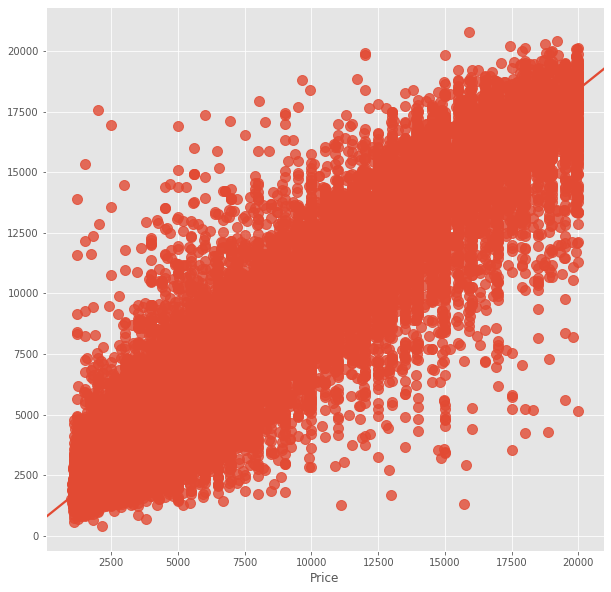

In [23]:
%%time
start_time = time.monotonic()

plt.style.use('ggplot') 
model_cat=CatBoostRegressor(depth=10,
                        iterations=700,
                        learning_rate=0.1,
                        loss_function='RMSE').fit(train_features,train_target,cat_features=cat_feat,verbose=100)
predict=model_cat.predict(valid_features)
rmse_CAT=mean_squared_error(predict,valid_tagret)
end_time = time.monotonic()
time_cat= timedelta(seconds=end_time - start_time)
print('RMSE: ',np.sqrt(rmse_CAT))
print ("Время выполнения:", time_cat)
result_cat = np.sqrt(rmse_CAT)
plt.figure( figsize= (10 , 10 )) 
sns.regplot(valid_tagret,  predict,  fit_reg= True,  scatter_kws= {"s":  100 });

Посмотрим также на важность каждого признака, которые позволяют увидеть связь каждого признака с целью прогнозирования.

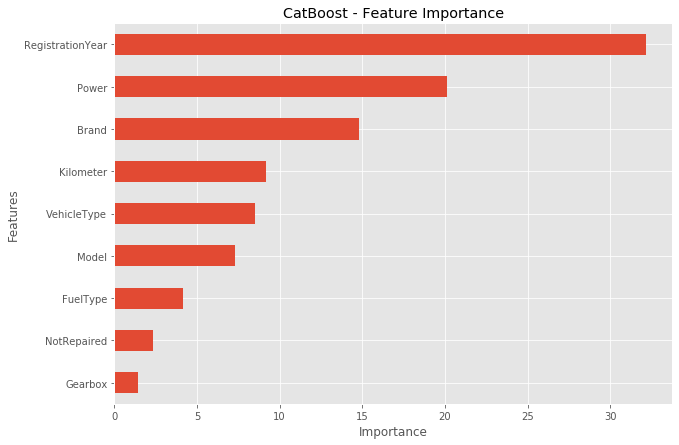

In [24]:
fea_imp = pd.DataFrame({'imp': model_cat.feature_importances_, 'col': train_features.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-10:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

**lightgbm regressor**


**Ohe**

Найдем категориальные признаки

In [25]:
cat_features_index=np.where(features.dtypes==np.object)
cat_features_index

(array([0, 2, 4, 6, 7, 8]),)

In [26]:
categorical_features=features.columns.get_values()[cat_features_index]

In [27]:
categorical_features

array(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand',
       'NotRepaired'], dtype=object)

Произведем перевод категориальных признаков в числовые с помощью OHE

In [28]:
features_lbm=pd.get_dummies(features,columns=categorical_features,drop_first=True)

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
получится около 300 факторов....<br>
    
Есть ещё ordinal-категоризация. Она более удобная может быть, когда такие факторы, как model, имеют большое количество категорий.

In [29]:
train_features_lbm,valid_features_lbm,train_target_lbm,valid_target_lbm=train_test_split(features_lbm,target,test_size=0.3,random_state=1234)

**также используем ordinal encoder для перевода в числовые признаки,чтобы потом сравнить резултаты работы моделей**

In [30]:
features_1 = features

In [31]:
encoder = OrdinalEncoder()

In [32]:
features_ord= pd.DataFrame(encoder.fit_transform(df[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand',
       'NotRepaired']]), columns = categorical_features)

In [33]:
features_ord

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
0,5.0,1.0,113.0,6.0,36.0,0.0
1,1.0,1.0,8.0,6.0,25.0,0.0
2,4.0,1.0,10.0,6.0,19.0,0.0
3,7.0,1.0,166.0,2.0,36.0,1.0
4,6.0,1.0,155.0,2.0,23.0,0.0
...,...,...,...,...,...,...
171126,4.0,1.0,137.0,2.0,30.0,0.0
171127,4.0,1.0,113.0,2.0,36.0,0.0
171128,4.0,1.0,137.0,6.0,30.0,1.0
171129,1.0,0.0,103.0,6.0,32.0,0.0


In [34]:
features_1[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand',
       'NotRepaired']] = features_ord[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand',
       'NotRepaired']].values

In [35]:
features_1.head(10)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
3,5.0,2001,1.0,75,113.0,150000,6.0,36.0,0.0
6,1.0,2004,1.0,109,8.0,150000,6.0,25.0,0.0
10,4.0,2004,1.0,105,10.0,150000,6.0,19.0,0.0
11,7.0,2005,1.0,140,166.0,150000,2.0,36.0,1.0
14,6.0,2011,1.0,190,155.0,70000,2.0,23.0,0.0
17,5.0,2004,0.0,75,220.0,150000,6.0,27.0,0.0
18,0.0,2007,1.0,136,59.0,150000,2.0,10.0,0.0
19,0.0,2004,1.0,102,32.0,150000,6.0,20.0,0.0
20,2.0,2009,1.0,160,195.0,100000,6.0,36.0,0.0
21,4.0,2002,0.0,231,15.0,150000,6.0,2.0,0.0


In [36]:
features_train_o, features_valid_o, target_train_o, target_valid_o = train_test_split(features_1, target, test_size=0.3, random_state=12345)

Параметры для обучающей модели

In [37]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 10, 
    'learning_rate': 0.1,
    'verbose': 0,
    'early_stopping_round': 20}
n_estimators =2000

In [38]:
%%time

start_time = time.monotonic()

d_train = lgb.Dataset(train_features_lbm, label=train_target_lbm)
d_valid = lgb.Dataset(valid_features_lbm, label=valid_target_lbm)
watchlist = [d_valid]

model = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=1)
preds = model.predict(valid_features_lbm)
rmse_ohe = mean_squared_error(preds,valid_target_lbm)
result_lgb_ohe = np.sqrt(rmse_ohe)
end_time = time.monotonic()
time_ohe= timedelta(seconds=end_time - start_time)
print('RMSE: ',np.sqrt(rmse_ohe))

print ("Время выполнения:", time_ohe)

[1]	valid_0's rmse: 4337.15
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 4041.22
[3]	valid_0's rmse: 3781.74
[4]	valid_0's rmse: 3554.37
[5]	valid_0's rmse: 3356.48
[6]	valid_0's rmse: 3181.09
[7]	valid_0's rmse: 3028.4
[8]	valid_0's rmse: 2893.15
[9]	valid_0's rmse: 2775.2
[10]	valid_0's rmse: 2673.19
[11]	valid_0's rmse: 2583.01
[12]	valid_0's rmse: 2502.62
[13]	valid_0's rmse: 2432.37
[14]	valid_0's rmse: 2370.26
[15]	valid_0's rmse: 2313.81
[16]	valid_0's rmse: 2264.66
[17]	valid_0's rmse: 2214.29
[18]	valid_0's rmse: 2175.23
[19]	valid_0's rmse: 2138.13
[20]	valid_0's rmse: 2106.35
[21]	valid_0's rmse: 2075.19
[22]	valid_0's rmse: 2051.31
[23]	valid_0's rmse: 2027.87
[24]	valid_0's rmse: 2005.03
[25]	valid_0's rmse: 1986.95
[26]	valid_0's rmse: 1967.56
[27]	valid_0's rmse: 1950.38
[28]	valid_0's rmse: 1934.82
[29]	valid_0's rmse: 1921.61
[30]	valid_0's rmse: 1909.08
[31]	valid_0's rmse: 1897.89
[32]	valid_0's rmse: 1886.71
[33]	valid_0's rmse: 1

Результаты опытов при изменении следующих гиперпараметров (при использовании OHE):

'max_depth': 10, 'learning_rate': 0.1,n_estimators = 2000 RMSE: 1559.75 CPU times: user 1min 43s, sys: 175 ms, total: 1min 43s
Wall time: 1min 45s

'max_depth': 10, 'learning_rate': 1,n_estimators = 2000 RMSE: 1643.99 CPU times: user 13.5 s, sys: 352 ms, total: 13.9 s
Wall time: 14.1 s

'max_depth': 5, 'learning_rate': 1,n_estimators = 2000 RMSE: 1584.73 CPU times: user 49.6 s, sys: 648 ms, total: 50.3 s
Wall time: 51.1 s

'max_depth': 10, 'learning_rate': 0.1,n_estimators = 700 RMSE:1599.64, CPU times: user 55.4 s, sys: 172 ms, total: 55.6 s
Wall time: 56.6 s

'max_depth': 3, 'learning_rate': 0.1,n_estimators = 700 RMSE:1721.07, CPU times: user 32.4 s, sys: 478 ms, total: 32.8 s
Wall time: 33.3 s

Графически отобразим соотношение предсказаний и target¶

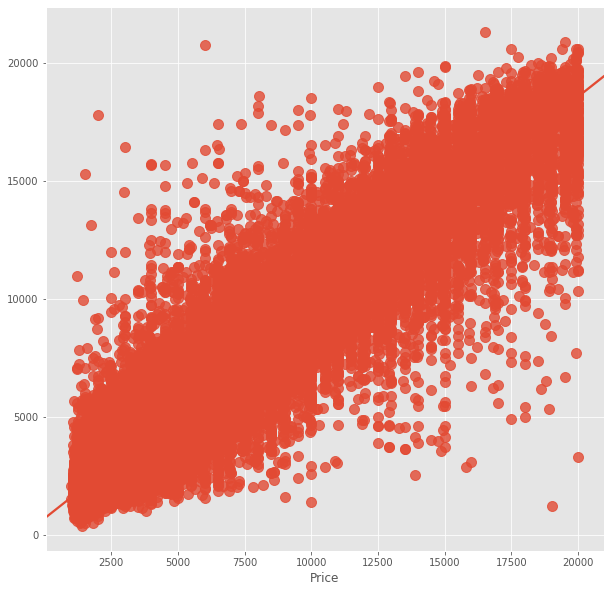

In [39]:
plt.figure( figsize= (10 , 10 )) 
sns.regplot(valid_target_lbm,  preds,  fit_reg= True,  scatter_kws= {"s":  100 });

**проведем аналогичные действия, но уже с числовыми признаками, полученными с помощью ordinal encoding**

In [40]:
%%time
start_time = time.monotonic()

d_train_o = lgb.Dataset(features_train_o, label=target_train_o)
d_valid_o = lgb.Dataset(features_valid_o, label=target_valid_o)
watchlist_o = [d_valid_o]

model_o = lgb.train(params, d_train_o, n_estimators, watchlist_o, verbose_eval=1)

preds_o = model_o.predict(features_valid_o)

rmse_ORD=mean_squared_error(preds_o,target_valid_o)
end_time = time.monotonic()
time_ord= timedelta(seconds=end_time - start_time)
result_lgb_ord = np.sqrt(rmse_ORD)

print('RMSE: ',np.sqrt(rmse_ORD))
print ("Время выполнения:", time_ord)


[1]	valid_0's rmse: 4345.94
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 4053.5
[3]	valid_0's rmse: 3796.33
[4]	valid_0's rmse: 3571.16
[5]	valid_0's rmse: 3374.44
[6]	valid_0's rmse: 3205.35
[7]	valid_0's rmse: 3055.05
[8]	valid_0's rmse: 2921.06
[9]	valid_0's rmse: 2805.59
[10]	valid_0's rmse: 2707.51
[11]	valid_0's rmse: 2619.72
[12]	valid_0's rmse: 2543.74
[13]	valid_0's rmse: 2476.84
[14]	valid_0's rmse: 2418.64
[15]	valid_0's rmse: 2365.7
[16]	valid_0's rmse: 2321.16
[17]	valid_0's rmse: 2275.66
[18]	valid_0's rmse: 2238.42
[19]	valid_0's rmse: 2205.37
[20]	valid_0's rmse: 2173.96
[21]	valid_0's rmse: 2136.82
[22]	valid_0's rmse: 2111.08
[23]	valid_0's rmse: 2084.94
[24]	valid_0's rmse: 2061.24
[25]	valid_0's rmse: 2039.87
[26]	valid_0's rmse: 2021.53
[27]	valid_0's rmse: 2004.85
[28]	valid_0's rmse: 1989.37
[29]	valid_0's rmse: 1973.86
[30]	valid_0's rmse: 1960.76
[31]	valid_0's rmse: 1950.02
[32]	valid_0's rmse: 1937.04
[33]	valid_0's rmse: 1

Результаты опытов при изменении следующих гиперпараметров (при использовании ordinal encoding):

'max_depth': 10, 'learning_rate': 0.1,n_estimators = 2000 RMSE: 1568.21 CPU times: user 1min 39s, sys: 92.7 ms, total: 1min 39s
Wall time: 1min 41s

'max_depth': 10, 'learning_rate': 1,n_estimators = 2000 RMSE: 1694.76 CPU times: user 11 s, sys: 98.2 ms, total: 11.1 s
Wall time: 11.3 s

'max_depth': 5, 'learning_rate': 1,n_estimators = 2000 RMSE: 1663 CPU times: user 20.2 s, sys: 121 ms, total: 20.3 s
Wall time: 20.6 s

'max_depth': 10, 'learning_rate': 0.1,n_estimators = 700 RMSE:1587.75, CPU times: user 39.9 s, sys: 237 ms, total: 40.2 s
Wall time: 40.8 s

'max_depth': 3, 'learning_rate': 0.1,n_estimators = 700 RMSE:1740.87, CPU times: user 38.6 s, sys: 246 ms, total: 38.9 s
Wall time: 39.6 s

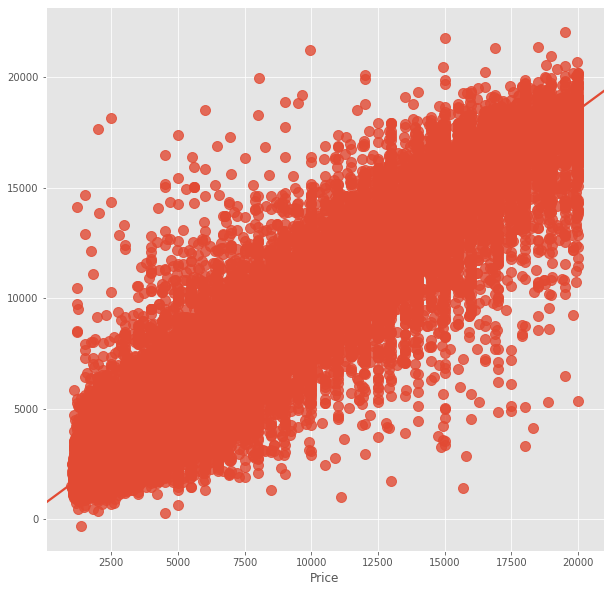

In [41]:
plt.figure( figsize= (10 , 10 )) 
sns.regplot(target_valid_o,  preds_o,  fit_reg= True,  scatter_kws= {"s":  100 });

# 3. Анализ моделей

In [43]:
rezume={'boosting':["CatBoosting","lightgbm regressor with one hot encoding","lightgbm regressor with ordinal encoding"],'RMSE':[result_cat,result_lgb_ohe,result_lgb_ord], 'time':[time_cat, time_ohe, time_ord]}
df_rezume = pd.DataFrame(rezume)
df_rezume['RMSE'].apply(lambda x: round(x, 2))
df_rezume

,boosting,RMSE,time
0,CatBoosting,1579.309509,00:07:53.459540
1,lightgbm regressor with one hot encoding,1559.745363,00:01:45.388472
2,lightgbm regressor with ordinal encoding,1568.208809,00:01:41.623380


Рассмотрев модель lightgbm regressor, можно сделать вывод, что лучшими гиперпараметрами в данном случае оказались 'max_depth': 10, 'learning_rate': 0.1,n_estimators = 2000, причем как в случае использования OHE для преобразования категориальных признаков в числовые, так как и в случае использования  ordinal encoder,  в первом случае лучший показатель  RMSE: 1559.75 при времени total: 1min 45s, а во втором случае лучший показатель RMSE: 1568.21 при времени  total: 1min 39s, поэтому видим, что OHE сработал, хоть и незначительно, но лучше, причем total также отличается незначительно.  Также мы видим, что качество предсказания резко ухудшается при изменении коэффициента скорости обучения, в частности при его увеличении, хотя и существенно уменьшается время, а также результат показывает себя не лучшим образом при изменении max_depth в меньшую сторону.

Если сравнивать с моделью Catboosting, то лучший результат получен при параметрах для CatBoosting: iterations=700,learning_rate=0.1,depth=10 RMSE:  1579.3095087397176
CPU times: user 7min 17s, sys: 37.7 s, total: 7min 54s
Wall time: 7min 57s, то есть результат не сильно отличается. Однако существенно отличается время total, более 7,5 мин в CatBoosting и всего около 1,5 мин в lightgbm, поэтому с точки зрения оперативности вычислений последний способ реализации градиентного бустинга смотрится привлекательнее.